In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
# pd.set_option('max_columns', None)  # show all columns
from sklearn.preprocessing import OneHotEncoder
#creating instance of one-hot-encoder
encoder = OneHotEncoder(handle_unknown='ignore')

In [2]:
df = pd.read_excel('../../DATAJAVI_V2_men.xlsx')
df_2 = pd.read_excel('../../DATAJAVI_V2_men.xlsx')  # to make changes

In [3]:
### eliminar variable Sexo y ShotID 
# 1. --> todo hombres --> Esta variable no aporta info alguna para el entrenamiento ML
# 2. Tampoco aporta info un ID incremental
columns_to_delete = ['Sexo', 'ShotID', 'EventID', 'startScore_Server', 'startScore_Receiver', 'shotCount', 
                     'serve_class', 'result', 'E<=1', 'E<=2', 'E<=4', 'E>4']
df.drop(columns=columns_to_delete, inplace=True)
df_2.drop(columns=columns_to_delete, inplace=True)

In [4]:
### Check how many rows have empty values or NaNs
print(df_2.isnull().sum().sum(), '/', len(df_2))  ### too many, we can't just delete rows with empty values --> interpolate

0 / 20454


In [5]:
df_2.describe()

,1º o 2º saque,Efectividad,Lado(1:Iguales;0:Ventaja),DIRECCIÓN:1 abierto;2 al cuerpo;3 a la T,V(km/h),[YA],ZA,Znet,TIME,difV,&(deg),ANG. IN,dLinea
count,20454.000000,20454.000000,20454.000000,20454.000000,20454.000000,20454.000000,20454.000000,20454.000000,20454.000000,20454.000000,20454.000000,20454.000000,20454.000000
mean,1.308399,3.032316,0.522343,2.070451,174.440181,1.762130,2.867122,1.149802,0.423751,8.692615,5.379175,11.423949,1.042840
std,0.461844,1.011730,0.499513,0.821516,19.411117,0.672477,0.151205,0.116511,0.052495,1.610355,4.859932,2.682266,0.566494
min,1.000000,1.000000,0.000000,1.000000,73.296000,0.005000,2.078000,0.937000,0.242000,-17.917227,0.033120,6.427432,0.000000
25%,1.000000,2.000000,0.000000,1.000000,160.596000,1.314250,2.780000,1.061000,0.384000,7.997143,2.603517,9.590657,0.574000
50%,1.000000,3.000000,1.000000,2.000000,176.184000,1.782000,2.851000,1.138000,0.416000,8.610471,4.360558,10.226733,1.003000
75%,2.000000,4.000000,1.000000,3.000000,189.036000,2.230000,2.936000,1.221000,0.458000,9.267095,5.980106,12.777876,1.529000
max,2.000000,4.000000,1.000000,3.000000,236.268000,4.714000,4.435000,2.281000,0.655000,35.427279,28.288601,26.452045,2.057000


In [6]:
df_2.to_csv('../predictions/df_2.csv')

In [7]:
df_2.Efectividad.values

array([2, 3, 2, ..., 4, 3, 4])

In [8]:
# sorted(df_2.columns)

startScore_Server  = [0 15 30 40 50 3 4 6 1 5 7 8 2 'WIN' 9 10 11 12 13]  
startScore_Receiver = [0 15 40 50 30 1 2 5 6 3 7 4 8 'LOS' 9 10 11 12 13]

I don't understand this variable ... not in a format the machine can understand. Delete for the moment

EventID: I don't think the machine can understand this variable for the moment ...   
   not clear how to show to the machine (162 events?)... we will show all events as one for the moment

In [9]:
corr = df_2.corr(method='pearson').Efectividad.sort_values(ascending=False)
correlated_cols = list(corr[corr>0].index)

In [10]:
correlated_cols

['Efectividad',
 'dLinea',
 'TIME',
 '1º o 2º saque',
 '[YA]',
 'Znet',
 'DIRECCIÓN:1 abierto;2 al cuerpo;3 a la T']

In [11]:
corr

Efectividad                                 1.000000
dLinea                                      0.244283
TIME                                        0.194283
1º o 2º saque                               0.169003
[YA]                                        0.076397
Znet                                        0.052546
DIRECCIÓN:1 abierto;2 al cuerpo;3 a la T    0.018908
Lado(1:Iguales;0:Ventaja)                  -0.015022
difV                                       -0.019550
ZA                                         -0.033600
ANG. IN                                    -0.081613
&(deg)                                     -0.137573
V(km/h)                                    -0.212049
Name: Efectividad, dtype: float64

#### **Conclusión:**
las correlaciones positivas son las que están correlacionadas con efectividad = 1,
pero las negativas pueden estar correlacionadas con efectividad nula, la cual es info válida tb.

Vamos a preparar dos datasets, uno con las positivas y otro con todas, Entrenar un par de modelos y sacar conclusiones.

Also, for the moment we are goind to delete the eventID --> 162 different events ... 

In [12]:
len(df)

20454

In [13]:
df_positive_corr = df[correlated_cols]
# df_positive_corr.head()

In [14]:
df_positive_corr_copy = df_positive_corr

## Filter Outliers

<AxesSubplot:>

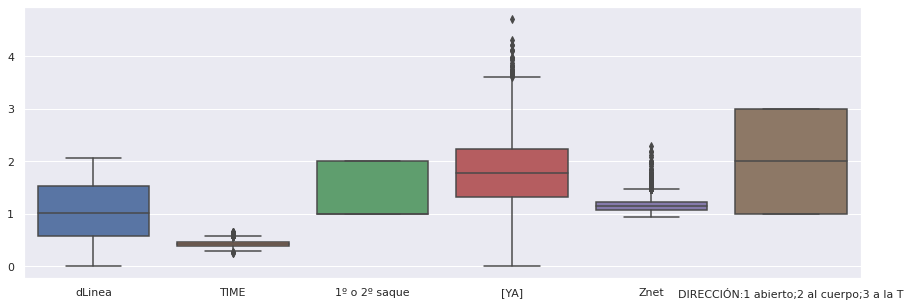

In [19]:
import numpy as np
import seaborn as sn
sn.set(rc={"figure.figsize":(15, 5)})
sn.boxplot(data=df_positive_corr)

In [20]:
### save as csv
### split before preprocessing, to avoid data leakage
XX, yy = df_positive_corr, df_positive_corr.Efectividad
XX.drop('Efectividad', axis=1, inplace=True)

# Creating a dataframe with 80%
# values of original dataframe
Xtrain = XX.sample(frac = 0.8)
Ytrain = yy.sample(frac = 0.8)
 
# Creating dataframe with
# rest of the 20% values
Xtest = XX.drop(Xtrain.index)
Ytest = yy.drop(Ytrain.index)

AttributeError: 'DataFrame' object has no attribute 'Efectividad'

In [17]:
Ytrain

11537    2
11038    3
8179     3
11892    2
11120    2
        ..
17056    2
7608     2
2179     3
18326    4
3511     3
Name: Efectividad, Length: 16363, dtype: int64

In [18]:
Xtrain.to_csv('../predictions/Xtrain.csv')
Ytrain.to_csv('../predictions/Ytrain.csv')
Xtest.to_csv('../predictions/Xtest.csv')
Ytest.to_csv('../predictions/Ytest.csv')

In [21]:
!pwd

/home/javier/mis_proyectos/tennis/EDA


### Algorithms:

In [21]:
# https://stackabuse.com/implementing-svm-and-kernel-svm-with-pythons-scikit-learn/
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

svclassifier = SVC(kernel='rbf')
svclassifier.fit(Xtrain, Ytrain)

y_pred = svclassifier.predict(Xtest)

print(confusion_matrix(Ytest, y_pred))
print(classification_report(Ytest, y_pred))

[[   0    0    0  347]
 [   0    0    0 1055]
 [   0    0    0  911]
 [   0    0    0 1778]]
              precision    recall  f1-score   support

           1       0.00      0.00      0.00       347
           2       0.00      0.00      0.00      1055
           3       0.00      0.00      0.00       911
           4       0.43      1.00      0.61      1778

    accuracy                           0.43      4091
   macro avg       0.11      0.25      0.15      4091
weighted avg       0.19      0.43      0.26      4091



/home/javier/pyenvs/tennis/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/javier/pyenvs/tennis/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/javier/pyenvs/tennis/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


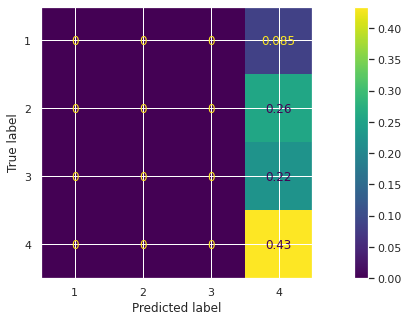

In [24]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(Ytest, y_pred, normalize='all')
cmd = ConfusionMatrixDisplay(cm, display_labels=['1','2', '3', '4'])
cmd.plot()

In [25]:
### apply zscore to X
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(Xtrain)
X_test_scaled = scaler.transform(Xtest)

model = SVC(kernel='rbf')
model.fit(X_train_scaled, Ytrain)
y_pred = model.predict(X_test_scaled)
print(classification_report(Ytest, y_pred))

              precision    recall  f1-score   support

           1       0.00      0.00      0.00       347
           2       0.00      0.00      0.00      1055
           3       0.00      0.00      0.00       911
           4       0.43      1.00      0.61      1778

    accuracy                           0.43      4091
   macro avg       0.11      0.25      0.15      4091
weighted avg       0.19      0.43      0.26      4091



/home/javier/pyenvs/tennis/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/javier/pyenvs/tennis/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/javier/pyenvs/tennis/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [26]:
X_train_scaled.shape, Ytrain.shape

((16363, 6), (16363,))

In [28]:
### save final dataset
import pickle as pkl

#to save it
with open("train.pkl", "wb") as f:
    pkl.dump([X_train_scaled, Ytrain], f)
    
#to save it
with open("test.pkl", "wb") as f:
    pkl.dump([X_test_scaled, Ytest], f)    

# #to load it
# with open("train.pkl", "r") as f:
#     train_x, train_y = pkl.load(f)

In [27]:
X_train_scaled

array([[0.17744288, 0.26150121, 0.        , 0.19031436, 0.11755952,
        1.        ],
       [0.98979096, 0.57869249, 1.        , 0.11363636, 0.2827381 ,
        0.5       ],
       [0.3033544 , 0.4527845 , 0.        , 0.42353441, 0.20758929,
        0.        ],
       ...,
       [0.6966456 , 0.33656174, 0.        , 0.37744265, 0.22247024,
        0.5       ],
       [0.82887701, 0.44067797, 0.        , 0.48513169, 0.21279762,
        0.5       ],
       [0.22022363, 0.27118644, 0.        , 0.11406117, 0.11309524,
        1.        ]])

In [29]:
X_train_scaled
X_test_scaled
Ytest
Ytrain

11537    2
11038    3
8179     3
11892    2
11120    2
        ..
17056    2
7608     2
2179     3
18326    4
3511     3
Name: Efectividad, Length: 16363, dtype: int64

## Try all possible algorithms and compare! 
Here starts the fun part 

## Lessons learnt - TODOES:  
- use df_3, not the top correlated df  
- using V vs Efectividad gives almos tthe same results!  
- Try all algorithms with all 3 X options!!  
    - V vs Efectividad
    - df_3 vs Efectividad
    - Max_correlated_vars_df vs Efectividad

In [30]:
import pickle

# https://stackabuse.com/implementing-svm-and-kernel-svm-with-pythons-scikit-learn/
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

### Load Data:
X_train_scaled, Ytrain = pickle.load(open("train.pkl", "rb"))  # X_train_scaled, y_train
X_test_scaled, Ytest = pickle.load(open("test.pkl", "rb"))     # 

### load the model
# model = pickle.load(open("model.pkl", "rb"))

## use model to predict
y_pred = model.predict(X_test_scaled)
print(classification_report(Ytest, y_pred))

              precision    recall  f1-score   support

           1       0.00      0.00      0.00       347
           2       0.00      0.00      0.00      1055
           3       0.00      0.00      0.00       911
           4       0.43      1.00      0.61      1778

    accuracy                           0.43      4091
   macro avg       0.11      0.25      0.15      4091
weighted avg       0.19      0.43      0.26      4091



/home/javier/pyenvs/tennis/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/javier/pyenvs/tennis/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/javier/pyenvs/tennis/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [32]:
y_train, y_test = Ytrain, Ytest

In [33]:
model = SVC(kernel='rbf')
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.00      0.00      0.00       347
           2       0.00      0.00      0.00      1055
           3       0.00      0.00      0.00       911
           4       0.43      1.00      0.61      1778

    accuracy                           0.43      4091
   macro avg       0.11      0.25      0.15      4091
weighted avg       0.19      0.43      0.26      4091



/home/javier/pyenvs/tennis/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/javier/pyenvs/tennis/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/javier/pyenvs/tennis/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [34]:
### Let's play with some Hyperparameters Cross-Validation search:
# C: Regularization parameter   -   float, default=1.0   -  Lambda in formulation
# gamma='scale' (default) is passed then it uses 1 / (n_features * X.var()) as value of gamma,

classification_report(y_test, y_pred, output_dict=True)['accuracy']

/home/javier/pyenvs/tennis/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/javier/pyenvs/tennis/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/javier/pyenvs/tennis/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.4346125641652408

In [35]:
X_train_scaled.var()

0.10007204328929373

In [36]:
gamma = 1 / (X_train_scaled.shape[1]*X_train_scaled.var())  # gamma = 1 / (n_features * X_train_scaled.var()) 
gamma  ### default gamma

1.6654668095949394

In [37]:
### create the values for the grid
C_search     = [0.01, 0.1, 0.5, 0.75, 1,   1.50, 2.0]
gamma_search = [0.01, 0.1, 0.5, 0.75, 1,   1.25, 1.5]

In [92]:
# from tqdm import tqdm
# results_dicto = []
# 
# for c in tqdm(C_search, desc='Iter. over Regularization parameter & kernel gammas'):
#     for g in gamma_search:
#         m = SVC(kernel='rbf', C=c, gamma=g)  # model  # tol = cost function tolerance
#         m.fit(X_train_scaled, y_train)
#         y_pred = m.predict(X_test_scaled)
#         cls_acc = classification_report(y_test, y_pred, output_dict=True)['accuracy']
#         results = {'lambda': m.C, 'gamma': m.gamma, 'accuracy': cls_acc}
#         results_dicto.append(results)
# 
# print()
# results_dicto

In [38]:
max([x['accuracy'] for x in nested_dicto]), m.C, m.gamma

NameError: name 'nested_dicto' is not defined

In [39]:
from numpy import mean
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from xgboost import XGBClassifier

In [40]:
"""
X_train_scaled, y_train
X_test_scaled, y_test
"""
model = XGBClassifier()
model.fit(X_train_scaled,y_train)

y_pred = model.predict(X_test_scaled)
print(classification_report(y_test, y_pred))

/home/javier/pyenvs/tennis/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[01:12:41] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           1       0.00      0.00      0.00       347
           2       0.23      0.08      0.11      1055
           3       0.23      0.04      0.07       911
           4       0.43      0.88      0.58      1778

    accuracy                           0.41      4091
   macro avg       0.23      0.25      0.19      4091
weighted avg       0.30      0.41      0.30      4091



array([[   0,   29,   18,  300],
       [   1,   80,   34,  940],
       [   4,   86,   35,  786],
       [   5,  152,   62, 1559]])

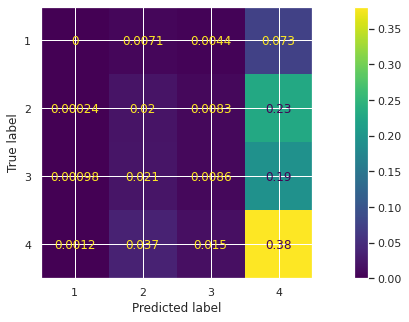

In [44]:
cm = confusion_matrix(Ytest, y_pred, normalize='all')
cmd = ConfusionMatrixDisplay(cm, display_labels=['1','2', '3', '4'])
cmd.plot()
confusion_matrix(Ytest, y_pred)

In [ ]:
from scipy import stats
from sklearn.model_selection import KFold
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb

clf_xgb = xgb.XGBClassifier(objective = 'binary:logistic')
param_dist = {'n_estimators': stats.randint(150, 1000),
              'learning_rate': stats.uniform(0.01, 0.59),
              'subsample': stats.uniform(0.3, 0.6),
              'max_depth': [3, 4, 5, 6, 7, 8, 9],
              'colsample_bytree': stats.uniform(0.5, 0.4),
              'min_child_weight': [1, 2, 3, 4]
             }

numFolds = 2
kfold_5 = KFold(n_splits=numFolds)

clf = RandomizedSearchCV(clf_xgb, 
                         param_distributions = param_dist,
                         cv = kfold_5,  
                         n_iter = 2, # you want 5 here not 25 if I understand you correctly 
                         scoring = 'roc_auc', 
                         error_score = 0, 
                         verbose = 3, 
                         n_jobs = -1)

clf.fit(X_train_scaled, y_train)


In [ ]:
from scipy import stats
from sklearn.model_selection import KFold
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb

clf_xgb = xgb.XGBClassifier(objective = 'binary:logistic')
param_dist = {'n_estimators': stats.randint(150, 1000),
              'learning_rate': stats.uniform(0.01, 0.59),
              'subsample': stats.uniform(0.3, 0.6),
              'max_depth': [3, 4, 5, 6, 7, 8, 9],
              'colsample_bytree': stats.uniform(0.5, 0.4),
              'min_child_weight': [1, 2, 3, 4]
             }

numFolds = 5
kfold_5 = KFold(n_splits=numFolds)

clf = RandomizedSearchCV(clf_xgb, 
                         param_distributions = param_dist,
                         cv = kfold_5,  
                         n_iter = 5, # you want 5 here not 25 if I understand you correctly 
                         scoring = 'roc_auc', 
                         error_score = 0, 
                         verbose = 3, 
                         n_jobs = -1)

clf.fit(X_train_scaled, y_train)


In [ ]:
y_pred = clf.predict(X_test_scaled)
print(classification_report(y_test, y_pred))

### Try so autoML frameworks

In [3]:
# ### not working on jupyter
# import autosklearn.classification
# cls = autosklearn.classificationcls.fit(X_train_scaled, y_train)
# y_pred = cls.predict(X_test_scaled)
# print(classification_report(y_test, y_pred))

### not working on jupyter

              precision    recall  f1-score   support

           1       0.00      0.00      0.00       347
           2       0.00      0.00      0.00      1055
           3       0.00      0.00      0.00       911
           4       0.43      1.00      0.61      1778

    accuracy                           0.43      4091
   macro avg       0.11      0.25      0.15      4091
weighted avg       0.19      0.43      0.26      4091



/home/javier/pyenvs/tennis/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/javier/pyenvs/tennis/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/javier/pyenvs/tennis/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


array([[   0,    0,    0,  347],
       [   0,    0,    0, 1055],
       [   0,    0,    0,  911],
       [   0,    0,    0, 1778]])

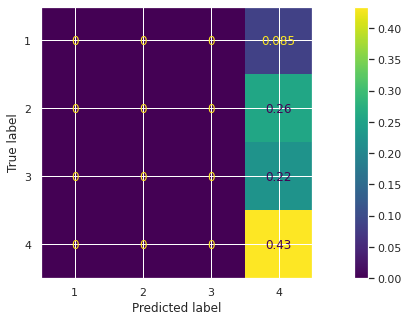

In [48]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

model = RandomForestClassifier(max_depth=2, random_state=0)
model.fit(X_train_scaled, y_train)   # X_train_scaled, y_train
y_pred = model.predict(X_test_scaled)
print(classification_report(y_test, y_pred))

cm = confusion_matrix(Ytest, y_pred, normalize='all')
cmd = ConfusionMatrixDisplay(cm, display_labels=['1','2', '3', '4'])
cmd.plot()
confusion_matrix(Ytest, y_pred)

[4 4 4 ... 4 4 4]
0.41603519921779514
              precision    recall  f1-score   support

           1       0.00      0.00      0.00       347
           2       0.24      0.05      0.08      1055
           3       0.21      0.02      0.04       911
           4       0.43      0.92      0.59      1778

    accuracy                           0.42      4091
   macro avg       0.22      0.25      0.18      4091
weighted avg       0.30      0.42      0.28      4091



array([[   0,   20,   10,  317],
       [   1,   51,   18,  985],
       [   0,   42,   20,  849],
       [   1,  100,   46, 1631]])

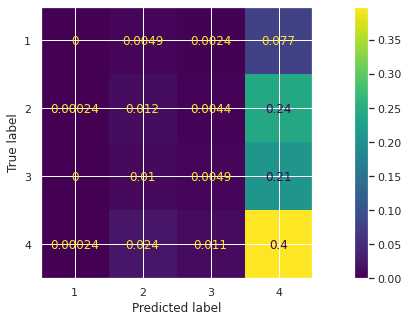

In [49]:
"""
X_train_scaled, y_train
X_test_scaled, y_test
"""

import lightgbm as lgb
from lightgbm import LGBMClassifier
 
# Skipping Data Exploration
# Dummification of Diagnosis Column (1-Benign, 0-Malignant Cancer)
# data['diagnosis']= pd.get_dummies(data['diagnosis'])
 
# Creating an object for model and fitting it on training data set
model = LGBMClassifier()
model.fit(X_train_scaled, y_train)
 
# Predicting the Target variable
pred = model.predict(X_test_scaled)
print(pred)
accuracy = model.score(X_test_scaled, y_test)
print(accuracy)

y_pred = model.predict(X_test_scaled)
print(classification_report(y_test, y_pred))

cm = confusion_matrix(Ytest, y_pred, normalize='all')
cmd = ConfusionMatrixDisplay(cm, display_labels=['1','2', '3', '4'])
cmd.plot()
confusion_matrix(Ytest, y_pred)